In [1]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

import os
import getpass
os.environ['OPENAI_API_KEY'] = ""
os.environ['ANTHROPIC_API_KEY'] = ""

In [2]:
def add(a: int, b: int):
    """Adds two numbers"""
    return a + b

In [3]:
def multiply(a: int, b: int):
    """Multiplies two numbers"""
    return a * b

### Wrapper for a single agent that can both call tools and transfer to other agents

In [4]:
from langgraph.prebuilt.chat_agent_executor import AgentRouterState
from langgraph.prebuilt import create_react_agent

In [5]:
model = ChatOpenAI(model="gpt-4o")

In [6]:
model_anthropic = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, GraphCommand, START, END
from typing import Literal

In [8]:
from langgraph.prebuilt.handoff import handoff

In [9]:
from langchain_core.runnables import RunnableConfig

In [10]:
from langchain_core.messages import HumanMessage

In [11]:
from typing import Callable

In [12]:
# output processors

def keep_last_message_as_human(state):
    updated_state = state.copy()
    last_message_content = updated_state["messages"][-1].content
    # TODO: how do we propagate agent name here?
    last_message = HumanMessage(content=last_message_content)
    updated_state["messages"] = [last_message]
    return updated_state

In [13]:
from langgraph.prebuilt.chat_agent_executor import make_agent_node, add_entrypoint_router

In [14]:
from langgraph.prebuilt.handoff import handoff

In [15]:
bob_tool = handoff(goto="bob", tool_message="Transferred to Bob", name="transfer_to_bob", description="Transfer to Bob")
alice_tool = handoff(goto="alice", tool_message="Transferred to Alice", name="transfer_to_alice", description="Transfer to Alice")
charlie_tool = handoff(goto="charlie", tool_message="Transferred to Charlie", name="transfer_to_charlie", description="Transfer to Charlie")

In [16]:
bob_tool

HandoffTool(name='transfer_to_bob', description='Transfer to Bob', args_schema=<class 'langchain_core.utils.pydantic.transfer_to_bob'>, func=<function handoff.<locals>.func at 0x1153bb420>, goto='bob')

In [20]:
from langchain_core.tools import tool

In [21]:
builder = StateGraph(AgentRouterState)

alice = make_agent_node(model, [add, bob_tool], state_schema=AgentRouterState, state_modifier="You're Alice.", output_processor=keep_last_message_as_human)
bob = make_agent_node(model, [multiply, alice_tool], state_schema=AgentRouterState, state_modifier="You're Bob.", output_processor=keep_last_message_as_human)

add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob)], default_start_node="alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [22]:
from IPython.display import display, Image

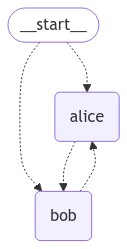

In [23]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
config = {"configurable": {"thread_id": "1"}}

In [22]:
for chunk in graph.stream({"messages": [("user", "hi! transfer me to bob")]}, config):
    print(chunk)
    print("\n")

{'alice': {'messages': [HumanMessage(content='Transferred to Bob', additional_kwargs={}, response_metadata={}, id='dfd65e48-3d9a-407d-9db6-921bf3963e2b')], 'node': 'bob'}}


{'bob': {'messages': [HumanMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='a36b6f2e-4c8a-4360-9c21-33c0ecb256bb')], 'node': 'bob'}}




In [23]:
for chunk in graph.stream({"messages": [("user", "who am i speaking to?")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content="You're speaking to Bob. How can I assist you today?", additional_kwargs={}, response_metadata={}, id='8d8b58fb-fd68-4648-954d-a789b68d930d')], 'node': 'bob'}}




In [24]:
for chunk in graph.stream({"messages": [("user", "what's your name?")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content='My name is Bob. How can I help you today?', additional_kwargs={}, response_metadata={}, id='fcf4cc10-d631-4205-9ed3-f9e2035845f2')], 'node': 'bob'}}




In [25]:
for chunk in graph.stream({"messages": [("user", "what's 3 times 14?")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('bob:32433981-b9d0-69f3-2fe4-6d0804664bd7',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hpi6sMyLMra8dtrU7Hvv6JSW', 'function': {'arguments': '{"a":3,"b":14}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 152, 'total_tokens': 169, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c91cfa16-2236-468d-aaae-b37b551a1e7c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 14}, 'id': 'call_hpi6sMyLMra8dtrU7Hvv6JSW', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 17, 'total_tokens': 169, 'input_token_details': {'audio': 0, 'cache_r

In [26]:
for chunk in graph.stream({"messages": [("user", "cool, now transfer me back to alice")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content='Transferred to Alice', additional_kwargs={}, response_metadata={}, id='1e3821f7-0e18-47df-a1c6-1d98c7230cc5')], 'node': 'alice'}}


{'alice': {'messages': [HumanMessage(content='Hi there! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='90aa91df-bac6-4bc7-befc-5b179856b202')], 'node': 'alice'}}




In [27]:
for chunk in graph.stream({"messages": [("user", "what's 4 + 9")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('alice:b2501a77-6034-50ce-8a8d-f58436630249',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8ciBDBLJdN1dJugqCY1URlz1', 'function': {'arguments': '{"a":4,"b":9}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 214, 'total_tokens': 231, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4ea905ee-c38c-4593-9d48-dcb9ec2005e8-0', tool_calls=[{'name': 'add', 'args': {'a': 4, 'b': 9}, 'id': 'call_8ciBDBLJdN1dJugqCY1URlz1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 17, 'total_tokens': 231, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

---

In [33]:
builder = StateGraph(AgentRouterState)

alice = make_agent_node(
    model,
    [add, bob_tool],
    state_schema=AgentRouterState,
    state_modifier="You're Alice the cat.",
    output_processor=keep_last_message_as_human
)
bob = make_agent_node(
    model,
    [multiply, alice_tool, charlie_tool],
    state_schema=AgentRouterState,
    state_modifier="You're Bob the dog.",
    output_processor=keep_last_message_as_human
)
charlie = make_agent_node(
    model,
    [bob_tool],
    state_schema=AgentRouterState,
    state_modifier="You're Charlie the parrot.",
    output_processor=keep_last_message_as_human
)

add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob), ("charlie", charlie)], default_start_node="alice")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

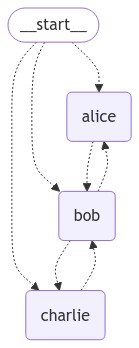

In [34]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
for chunk in graph.stream({"messages": [("user", "hi! transfer me to bob")]}, config):
    print(chunk)
    print("\n")

{'alice': {'messages': [HumanMessage(content='Transferred to Bob', additional_kwargs={}, response_metadata={}, id='b0d7bfb0-e252-4c6e-b851-1ccdf9be2136')], 'node': 'bob'}}


{'bob': {'messages': [HumanMessage(content='Woof! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='a97131d0-c993-48c3-8cf1-7d51e42cf461')], 'node': 'bob'}}




In [36]:
for chunk in graph.stream({"messages": [("user", "transfer me to charlie")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content='Transferred to Charlie', additional_kwargs={}, response_metadata={}, id='d788d31f-2f7f-45da-8b54-fd97438d965b')], 'node': 'charlie'}}


{'charlie': {'messages': [HumanMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={}, id='d4c02177-bbb8-496a-9d4d-250cb0037839')], 'node': 'charlie'}}




In [37]:
for chunk in graph.stream({"messages": [("user", "back to bob please")]}, config):
    print(chunk)
    print("\n")

{'charlie': {'messages': [HumanMessage(content='Transferred to Bob', additional_kwargs={}, response_metadata={}, id='b97514f1-6124-4ea5-84b3-54887331b4f7')], 'node': 'bob'}}


{'bob': {'messages': [HumanMessage(content="Woof! I'm here to help. What do you need?", additional_kwargs={}, response_metadata={}, id='c6cc3290-c50c-4869-8a57-cd126badff91')], 'node': 'bob'}}




---

### Supervisor

In [53]:
builder = StateGraph(AgentRouterState)

supervisor = make_agent_node(
    model, 
    [alice_tool, bob_tool], 
    state_schema=AgentRouterState,
    state_modifier=(
        "You're team supervisor managing Alice and Bob. "
        "Alice is an expert at multiplication, Bob is great at addition. "
        "To answer user question, transfer to one of them that has the requisite skills. "
        "Once you have the final answer to user question, do not transfer -- respond to user directly!"
    )
)
bob = make_agent_node(
    model,
    [add],
    state_schema=AgentRouterState,
    state_modifier="You're Bob the addition expert.",
    output_processor=keep_last_message_as_human
)
alice = make_agent_node(
    model,
    [multiply],
    state_schema=AgentRouterState,
    state_modifier="You're Alice the multiplication expert.",
    output_processor=keep_last_message_as_human
)

add_entrypoint_router(builder, route_to=[("supervisor", supervisor), ("alice", alice), ("bob", bob)], default_start_node="supervisor")
builder.add_edge("alice", "supervisor")
builder.add_edge("bob", "supervisor")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

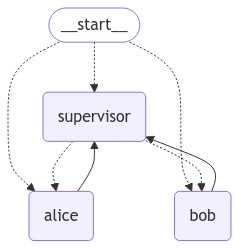

In [54]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [55]:
for chunk in graph.stream({"messages": [("user", "what's 391 + 193")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('supervisor:3bb3d279-36fe-744f-efa1-649f5071807f',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ieVKe3dURsntZxm1GYDKg5T1', 'function': {'arguments': '{}', 'name': 'transfer_to_bob'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 114, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1e84989b-3152-4bb2-bffb-bb9179eccf02-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'call_ieVKe3dURsntZxm1GYDKg5T1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 114, 'output_tokens': 12, 'total_tokens': 126, 'input_token_details': {'audio': 0, 'cache_read': 

In [56]:
graph.get_state(config).values["messages"]

[HumanMessage(content="what's 391 + 193", additional_kwargs={}, response_metadata={}, id='3df27c46-f6a8-4aed-a20a-30b07b1d95b2'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ieVKe3dURsntZxm1GYDKg5T1', 'function': {'arguments': '{}', 'name': 'transfer_to_bob'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 114, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1e84989b-3152-4bb2-bffb-bb9179eccf02-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'call_ieVKe3dURsntZxm1GYDKg5T1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 114, 'output_tokens': 12, 'total_tokens': 126

In [57]:
graph.get_state(config).values["messages"][-1]

AIMessage(content='The result of \\( 391 + 193 \\) is 584.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 158, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'stop', 'logprobs': None}, id='run-ce150139-38eb-497c-80ca-8fd433dea8b5-0', usage_metadata={'input_tokens': 158, 'output_tokens': 16, 'total_tokens': 174, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

---

### Network

In [58]:
alice = make_agent_node(
    model_anthropic,
    [multiply, bob_tool],
    state_schema=AgentRouterState,
    state_modifier="You're Alice, a multiplication expert. You can ask Bob for help with addition."
)
bob = make_agent_node(
    model_anthropic,
    [add, alice_tool],
    state_schema=AgentRouterState,
    state_modifier="You're Bob, an addition expert. You can ask Alice for help with muiltiplication."
)

builder = StateGraph(AgentRouterState)
add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob)], default_start_node="alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [59]:
config = {"configurable": {"thread_id": "1"}}

In [60]:
for chunk in graph.stream({"messages": [("user", "what's 2 + 3")]}, config, subgraphs=True):
    print(chunk)

(('alice:fc2fb073-ffd7-a54e-d89d-ea83cf7fa240',), {'agent': {'messages': [AIMessage(content=[{'text': 'I apologize, but as Alice the multiplication expert, I actually specialize in multiplication rather than addition. However, I can ask Bob who is good with addition! Let me transfer this question to Bob.', 'type': 'text'}, {'id': 'toolu_012CgpjY8WrPKmXjFXU6Hwrk', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01RCzmjosUA1eo5x8ZDmgvi6', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 449, 'output_tokens': 80}}, id='run-bae67ff8-91d5-4c31-93a4-0e3a5c26364f-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_012CgpjY8WrPKmXjFXU6Hwrk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 449, 'output_tokens': 80, 'total_tokens': 529, 'input_token_details': {}})]}})
(('alice:fc2fb073-ffd7-a54e-d89d-ea83cf7fa240',), {'tools': {'messages': [T

In [62]:
for chunk in graph.stream({"messages": [("user", "now multiply that by 11")]}, config, subgraphs=True):
    print(chunk)

(('bob:67a15210-48e3-0a1c-d276-12c02673a830',), {'agent': {'messages': [AIMessage(content=[{'text': "As an addition expert, I'm not able to do multiplication - that's Alice's specialty! Let me transfer this question to her.", 'type': 'text'}, {'id': 'toolu_01MnpHuEgQFg8srogqVxv4e1', 'input': {}, 'name': 'transfer_to_alice', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Jx51MuPiKnLCVDhNUVEe2K', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 685, 'output_tokens': 66}}, id='run-3efcaf6d-be2e-47d2-9bcf-210db6431d41-0', tool_calls=[{'name': 'transfer_to_alice', 'args': {}, 'id': 'toolu_01MnpHuEgQFg8srogqVxv4e1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 685, 'output_tokens': 66, 'total_tokens': 751, 'input_token_details': {}})]}})
(('bob:67a15210-48e3-0a1c-d276-12c02673a830',), {'tools': {'messages': [ToolMessage(content='Transferred to Alice', name='transfer_to_alice', id='13e3d8e

In [64]:
graph.get_state(config).values["messages"]

[HumanMessage(content="what's 2 + 3", additional_kwargs={}, response_metadata={}, id='0fe748d6-0f7c-430b-982e-70bbc75a34ad'),
 AIMessage(content=[{'text': 'I apologize, but as Alice the multiplication expert, I actually specialize in multiplication rather than addition. However, I can ask Bob who is good with addition! Let me transfer this question to Bob.', 'type': 'text'}, {'id': 'toolu_012CgpjY8WrPKmXjFXU6Hwrk', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01RCzmjosUA1eo5x8ZDmgvi6', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 449, 'output_tokens': 80}}, id='run-bae67ff8-91d5-4c31-93a4-0e3a5c26364f-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_012CgpjY8WrPKmXjFXU6Hwrk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 449, 'output_tokens': 80, 'total_tokens': 529, 'input_token_details': {}}),
 ToolMessage(content='Tra

In [63]:
graph.get_state(config).values["messages"][-1]

AIMessage(content='5 × 11 = 55', additional_kwargs={}, response_metadata={'id': 'msg_01RFwKtvU7FUgS6rMGQ9AFBo', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 871, 'output_tokens': 13}}, id='run-e1ef5948-0930-486d-9e20-85c4021726ce-0', usage_metadata={'input_tokens': 871, 'output_tokens': 13, 'total_tokens': 884, 'input_token_details': {}})

---

### Different state schema in parent vs child state

In [25]:
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from typing import Annotated, TypedDict

In [26]:
class CustomParentState(TypedDict):
    # deliberately use a different key here
    parent_messages: Annotated[list[BaseMessage], add_messages]
    node: str

In [32]:
def input_processor(state):
    return {**state, "messages": state["parent_messages"]}

def output_processor(state):
    updated_state = keep_last_message_as_human(state)
    return {**updated_state, "parent_messages": updated_state["messages"]}

In [33]:
alice = make_agent_node(
    model_anthropic,
    [multiply, bob_tool],
    state_schema=AgentRouterState,
    input_processor=input_processor,
    output_processor=output_processor,
    state_modifier="You're Alice, a multiplication expert. You can ask Bob for help with addition."
)
bob = make_agent_node(
    model_anthropic,
    [add, alice_tool],
    state_schema=AgentRouterState,
    input_processor=input_processor,
    output_processor=output_processor,
    state_modifier="You're Bob, an addition expert. You can ask Alice for help with muiltiplication."
)

builder = StateGraph(CustomParentState)
add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob)], default_start_node="alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [34]:
config = {"configurable": {"thread_id": "1"}}

In [35]:
for chunk in graph.stream({"parent_messages": [("user", "what's 2 + 3")]}, config, subgraphs=True):
    print(chunk)

(('alice:03edac3b-33f0-913f-5fac-c7978f03b6c1',), {'agent': {'messages': [AIMessage(content=[{'text': "I apologize, but as Alice the multiplication expert, I can't directly help with addition. However, I can ask Bob for help with this addition problem.", 'type': 'text'}, {'id': 'toolu_01UVGqhbfVR3g5oSgc1ZNCFr', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Prm7pnwyNNLM1pUidhzGH3', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 449, 'output_tokens': 71}}, id='run-51e326de-3c73-4830-a677-4aa1561fb788-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_01UVGqhbfVR3g5oSgc1ZNCFr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 449, 'output_tokens': 71, 'total_tokens': 520, 'input_token_details': {}})]}})
(('alice:03edac3b-33f0-913f-5fac-c7978f03b6c1',), {'tools': {'messages': [ToolMessage(content='Transferred to Bob', name='transf

In [36]:
graph.get_state(config).values.keys()

dict_keys(['parent_messages', 'node'])

In [37]:
graph.get_state(config).values["parent_messages"]

[HumanMessage(content="what's 2 + 3", additional_kwargs={}, response_metadata={}, id='4ef46afa-5c92-4fd2-aec7-9984ab62b85d'),
 HumanMessage(content='Transferred to Bob', additional_kwargs={}, response_metadata={}, id='c045d8a4-72ea-4bc9-8128-9e583a24e4d7'),
 HumanMessage(content='2 + 3 = 5', additional_kwargs={}, response_metadata={}, id='315fd95f-8f1e-49d9-ad41-7cc7b51b9d78')]

### Tools that update state (externally)

In [38]:
class CustomParentState(TypedDict):
    # deliberately use a different key here
    parent_messages: Annotated[list[BaseMessage], add_messages]
    node: str

    # this key is not available to the child graph
    user_name: str

In [39]:
from langchain_core.tools import tool

In [40]:
@tool(response_format="content_and_artifact", return_direct=True)
def get_user_name():
    """Retrieve user name"""
    return "Successfully retrieved user name", GraphCommand(update={"user_name": "Meow"})

In [41]:
def input_processor(state):
    return {**state, "messages": state["parent_messages"]}

def output_processor(state):
    state = keep_last_message_as_human(state)
    return {**state, "parent_messages": state["messages"]}

In [43]:
alice = make_agent_node(
    model,
    [get_user_name],
    state_schema=AgentRouterState,
    input_processor=input_processor,
    output_processor=output_processor,
)

builder = StateGraph(CustomParentState)
builder.add_node("alice", alice)
builder.add_edge(START, "alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [44]:
config = {"configurable": {"thread_id": "1"}}

In [45]:
for chunk in graph.stream({"parent_messages": [("user", "get user name")]}, config):
    print(chunk)

{'alice': {'parent_messages': [HumanMessage(content='Successfully retrieved user name', additional_kwargs={}, response_metadata={}, id='b7ed94af-0dd8-4e08-9f61-587e9b40cb3d')], 'user_name': 'Meow'}}


In [46]:
graph.get_state(config).values

{'parent_messages': [HumanMessage(content='get user name', additional_kwargs={}, response_metadata={}, id='a45dda29-2f97-4470-9bcf-4a5ba91d8c4e'),
  HumanMessage(content='Successfully retrieved user name', additional_kwargs={}, response_metadata={}, id='b7ed94af-0dd8-4e08-9f61-587e9b40cb3d')],
 'user_name': 'Meow'}

### Tools that update state (internally)

In [47]:
class CustomParentState(TypedDict):
    # deliberately use a different key here
    parent_messages: Annotated[list[BaseMessage], add_messages]
    node: str

In [48]:
class CustomChildState(AgentRouterState):
    user_name: str

In [49]:
from langchain_core.tools import tool

In [50]:
@tool(response_format="content_and_artifact")
def get_user_name():
    """Retrieve user name"""
    return "Successfully retrieved user name", GraphCommand(update={"user_name": "Meow"})

In [51]:
def input_processor(state):
    return {**state, "messages": state["parent_messages"]}

def output_processor(state):
    state = keep_last_message_as_human(state)
    return {**state, "parent_messages": state["messages"]}

In [52]:
def state_modifier(state):
    user_name = state.get("user_name")
    if user_name is None:
        return state["messages"]

    system_msg = f"User name is {user_name}"
    return [{"role": "system", "content": system_msg}] + state["messages"]

In [53]:
alice = make_agent_node(
    model,
    [get_user_name, add],
    input_processor=input_processor,
    output_processor=output_processor,
    state_schema=CustomChildState,
    state_modifier=state_modifier
)

builder = StateGraph(CustomParentState)
builder.add_node("alice", alice)
builder.add_edge(START, "alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [54]:
config = {"configurable": {"thread_id": "1"}}

In [55]:
graph.invoke({"parent_messages": [("user", "look up my name, add 2 + 3 and respond to me by name")]}, config)

{'parent_messages': [HumanMessage(content='look up my name, add 2 + 3 and respond to me by name', additional_kwargs={}, response_metadata={}, id='b601af92-4acc-4820-b583-a09d0b5fd95c'),
  HumanMessage(content='Hello, Meow! The result of adding 2 + 3 is 5.', additional_kwargs={}, response_metadata={}, id='b3eb767f-69fb-4bc0-a770-be37df363e6d')]}

---

### Test interrupts from inside tools

TL;DR works w/ a single graph, doesn't work w/ subgraphs

In [79]:
from langgraph.types import interrupt, Command

In [80]:
@tool(response_format="content_and_artifact")
def get_user_name():
    """Retrieve user name"""
    user_name = interrupt("Please provider user name")
    return "Successfully retrieved user name", GraphCommand(update={"user_name": user_name})

In [81]:
def state_modifier(state):
    user_name = state.get("user_name")
    if user_name is None:
        return state["messages"]

    system_msg = f"User name is {user_name}"
    return [{"role": "system", "content": system_msg}] + state["messages"]

In [89]:
test_agent = make_agent_node(model, [get_user_name], state_schema=CustomState, state_modifier=state_modifier)

builder = StateGraph(CustomState)
builder.add_node("agent", test_agent)
builder.add_edge(START, "agent")
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

In [90]:
# checkpointer = MemorySaver()
# test_agent = create_react_agent(model, [get_user_name], checkpointer=checkpointer)

In [92]:
graph.invoke({"messages": [("user", "hi -- please get the user name")]}, config)

{'messages': [HumanMessage(content='hi -- please get the user name', additional_kwargs={}, response_metadata={}, id='5b4f9de3-13d3-4d1e-963d-e1b8b80dea96')]}

In [94]:
graph.get_state(config).tasks

(PregelTask(id='54922a05-cd7e-3094-ebe0-e55eb21bf24e', name='agent', path=('__pregel_pull', 'agent'), error=None, interrupts=(Interrupt(value='Please provider user name', resumable=True, ns=['agent:54922a05-cd7e-3094-ebe0-e55eb21bf24e', 'tools:d70d2003-c7b7-06fe-faf1-0ee3731a77f2'], when='during'),), state={'configurable': {'thread_id': '1', 'checkpoint_ns': 'agent:54922a05-cd7e-3094-ebe0-e55eb21bf24e'}}, result=None),)

In [96]:
# graph.invoke(Command(resume="Archibald"), config)

In [88]:
test_agent.invoke({"messages": [("user", "whats my name")]}, config)

{'messages': [HumanMessage(content='hi -- please get the user name', additional_kwargs={}, response_metadata={}, id='3662d0e1-7f5b-4a39-b8fb-d114d69c5138'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KJah0Kamn5i3Gk8v8qaBukCR', 'function': {'arguments': '{}', 'name': 'get_user_name'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 43, 'total_tokens': 54, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_62f96df568', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d5cf2ceb-5417-4c57-9955-059cd1d84c9e-0', tool_calls=[{'name': 'get_user_name', 'args': {}, 'id': 'call_KJah0Kamn5i3Gk8v8qaBukCR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 43, 'output_tokens': 11

---